# Inherently Multidimensional Data: xarray (& Iris)

- **Prerequisites**:
  - Ideally, pandas

- **Objectives:**

  - Get a quick overview

## Foreword

- NumPy's array is N-dimensional
- N-dimensional data can be flattened, i.e. represented as 2D
- Flattening may be undesireable
- pandas supports/facilitates many common data processing operations
- pandas provides a high-level data structure, however, the DataFrame specifically targets tabular data

**How about pandas-like functionality for >2D?**

## Prelude

---

Examples partly based on [here](https://github.com/lumbric/presentations/blob/master/2019-09-25_pyugat_xarray_overview/xarray-demo.ipynb).

### >2D dimensional data is harder to work with

In [1]:
import numpy as np
data = np.arange(12).reshape((3, 2, 2))
data  # what is data.sum(axis=1)?

array([[[ 0,  1],
        [ 2,  3]],

       [[ 4,  5],
        [ 6,  7]],

       [[ 8,  9],
        [10, 11]]])

In [2]:
# what is the result of this simple operation?
data.sum(axis=1)

array([[ 2,  4],
       [10, 12],
       [18, 20]])

In [3]:
data[0, :, 0], data[0, :, 1], data[1, :, 0], data[1, :, 1]  # and so on

(array([0, 2]), array([1, 3]), array([4, 6]), array([5, 7]))

In [4]:
# flattening
import pandas as pd

x_index = ['x0', 'x1']
y_index = ['y0', 'y1']

df = pd.DataFrame(np.arange(4).reshape(2, 2), columns=x_index, index=y_index)
print('2D:', df, '2D flattened:', df.unstack(), sep='\n\n')

2D:

    x0  x1
y0   0   1
y1   2   3

2D flattened:

x0  y0    0
    y1    2
x1  y0    1
    y1    3
dtype: int64


### Broadcasting very powerful but not obvious

In [5]:
a = np.arange(5)
a

array([0, 1, 2, 3, 4])

In [6]:
b = np.ones(5)
b

array([1., 1., 1., 1., 1.])

In [7]:
b[np.newaxis, :].shape

(1, 5)

In [8]:
a[:, np.newaxis] * b[np.newaxis, :]

array([[0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [2., 2., 2., 2., 2.],
       [3., 3., 3., 3., 3.],
       [4., 4., 4., 4., 4.]])

### It's supposed to be easy

In [9]:
import xarray as xr
a_xr = xr.DataArray(a, dims='a_dim')
b_xr = xr.DataArray(b, dims='b_dim')

In [10]:
a_xr

<xarray.DataArray (a_dim: 5)>
array([0, 1, 2, 3, 4])
Dimensions without coordinates: a_dim

In [11]:
b_xr

<xarray.DataArray (b_dim: 5)>
array([1., 1., 1., 1., 1.])
Dimensions without coordinates: b_dim

In [12]:
a_xr * b_xr

<xarray.DataArray (a_dim: 5, b_dim: 5)>
array([[0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [2., 2., 2., 2., 2.],
       [3., 3., 3., 3., 3.],
       [4., 4., 4., 4., 4.]])
Dimensions without coordinates: a_dim, b_dim

### Dummy example

In [13]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [14]:
latitude_resolution = 100
longitude_resolution = 110
time_resolution = 365

# in m/s
wind_speeds = np.random.weibull(10, size=(latitude_resolution, longitude_resolution, time_resolution))
wind_speeds.shape

(100, 110, 365)

In [15]:
_ = plt.hist(wind_speeds.flatten(), density=True, bins=50)

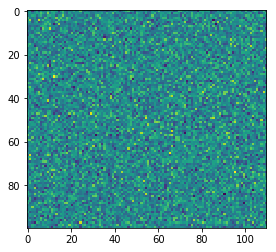

In [16]:
# m/s --> kW
wind_to_power = np.random.normal(300, scale=20, size=(latitude_resolution, longitude_resolution))
plt.imshow(wind_to_power)

In [17]:
# compute power
average_power = wind_to_power * wind_speeds

ValueError: operands could not be broadcast together with shapes (100,110) (100,110,365) 

In [18]:
wind_speeds.shape, wind_to_power.shape

((100, 110, 365), (100, 110))

In [19]:
average_power = (wind_to_power * np.rollaxis(wind_speeds, 2)).mean(axis=0)
average_power.shape

(100, 110)

### Dummy example (the xarray way)

In [20]:
wind_speeds_raw = np.random.weibull(10, size=(latitude_resolution, longitude_resolution, time_resolution))
wind_speeds = xr.DataArray(wind_speeds_raw, dims=('latitude', 'longitude', 'time'))
wind_speeds

<xarray.DataArray (latitude: 100, longitude: 110, time: 365)>
array([[[0.96652933, 0.96378178, 0.91980656, ..., 0.83932642,
         0.97406491, 1.06022003],
        [1.01127868, 0.9280693 , 0.91327406, ..., 1.12735559,
         1.03802374, 1.10208083],
        [0.77832175, 1.02199288, 0.87764178, ..., 1.04085751,
         1.02358819, 1.04490311],
        ...,
        [0.90680112, 1.11566688, 1.00011895, ..., 0.84737069,
         0.86239702, 0.93229888],
        [0.91972219, 1.05035923, 0.92266062, ..., 0.95531238,
         0.93091706, 1.02180405],
        [0.88545416, 1.09443055, 1.1257205 , ..., 0.96386327,
         1.06690563, 0.84442025]],

       [[0.80989539, 1.05548519, 0.96854686, ..., 0.83951845,
         0.8533893 , 1.11947766],
        [1.16973293, 0.71623707, 0.89035587, ..., 0.9560643 ,
         1.08966515, 1.06407637],
        [0.84044554, 1.00227374, 0.85988141, ..., 0.96632023,
         0.88728741, 1.05391847],
        ...,
        [0.98962779, 0.88686405, 0.95770513, .

In [21]:
wind_to_power_raw = np.random.normal(300, scale=20, size=(latitude_resolution, longitude_resolution))
wind_to_power = xr.DataArray(wind_to_power_raw, dims=('latitude', 'longitude'))

In [22]:
average_power = (wind_to_power * wind_speeds).mean(dim='time')
average_power

<xarray.DataArray (latitude: 100, longitude: 110)>
array([[288.91095452, 275.08310127, 265.17399616, ..., 294.97435846,
        276.37560534, 304.83351615],
       [283.2448001 , 288.00630934, 285.00019134, ..., 301.35601887,
        286.99024491, 300.862025  ],
       [283.32801689, 300.10747859, 320.81652275, ..., 286.32320133,
        297.97308342, 282.48214092],
       ...,
       [276.95538291, 277.35589086, 314.61833573, ..., 290.56189381,
        301.28644066, 302.758162  ],
       [309.3219542 , 254.18092734, 289.10338664, ..., 264.18031116,
        282.94997711, 298.29093238],
       [278.25522753, 258.098752  , 268.79662051, ..., 301.93569708,
        304.89582245, 282.1449272 ]])
Dimensions without coordinates: latitude, longitude

## Foreword (continued)

**Desireable features:**
- Labelled dimensions
- Automatic alignment/broadcasting/processing along/on these dimension
- Time Series Support
- GroupBy-like facilities
- ...

## What are xarray (& Iris)?

### Iris: A Python library for Meteorology and Climatology

<img src="./images/iris-logo.png" alt="Iris" width="100.px">

[Iris](http://scitools.org.uk/iris/) (by [UK Met Office](http://www.metoffice.gov.uk/)):
> The Iris library implements a **data model** to create a **data abstraction** layer which **isolates analysis and visualisation** code **from data format specifics**. The data model we have chosen is the **CF Data Model**. The implementation of this model we have called an **´Iris Cube´**.

> Iris currently supports **read/write access** to a **range of data formats**, including (CF-)netCDF, GRIB, and PP; **fundamental data manipulation operations**, such as arithmetic, interpolation, and statistics; and a range of **integrated plotting options**.


### xarray: N-D labeled arrays and datasets in Python

<img src="./images/xarray-logo.png" alt="xarray" width="250.px">

[xarray](http://xarray.pydata.org/en/stable/) (originated at [The Climate Corporation](http://climate.com/), now part of [PyData](https://pydata.org/)):
> xarray (formerly xray) is an open source project and Python package that aims to bring the **labeled data power of pandas** to the **physical sciences**, by **providing N-dimensional variants of the core pandas data structures**.

> Our goal is to provide a **pandas-like and pandas-compatible toolkit for analytics on multi-dimensional arrays**, rather than the tabular data for which pandas excels. Our approach adopts the **Common Data Model** for self- describing scientific data in widespread use in the Earth sciences: **`xarray.Dataset`** is an in-memory representation of a **netCDF** file.

### HPC

Both xarray and Iris support **parallelization** through **dask**.

(Lazy) loading of multiple files.

### What is the difference between Iris & xarray?

**Philosophy/Design:**
- Iris specifically targets meteorological and oceanographic data 
- xarray is based on pandas

**Details:**
- metadata handling, plotting, ...
- currently no direct (in-memory) conversion between Iris and xarray data structures


[netCDF4-python](https://github.com/Unidata/netcdf4-python) provides a lower level interface to netCDF files. It is used internally by both Iris and xarray.

Iris' **`Cube`** inspired xarray's **`DataArray`**.

### When to use what and why?

*this is of course subjective*

**Considerations:**
- In general: prefer high-level libraries over low-level libraries
  - implemeting code/tools to express your data as high-level data structure is relatively easy
  - leverage high-level functionality - this is typically hard to do it yourself (e.g. groupby, resample, ...)
- If there is a coherent, well-established standard in your team, go with it.
- If your data is not fundamentally multi-dimensional, stick with pandas.
- If you want/need PyData ecosystem integragtion, try xarray.
- If you want/need application specific code, try Iris.
- In any case: try both xarray and Iris to see which suits your needs best.
 
Compare the extremes:
- Data sets that are aligned only along one dimension, e.g. time, a very well handled using pandas.
- Data sets that are aligned along (x, y, z, time) benefit from a higher-dimensional data structure.



# A quick Look at xarray
## [`xarray.DataArray`](http://xarray.pydata.org/en/stable/data-structures.html#dataarray)
Plain data:
<img src="./images/multi_array.png" alt="Multi Array" width="250.px">
Appropriate high-level data structure:
<img src="./images/multi_array_to_cube.png" alt="Multi Array" width="300.px">

Pictures taken from [Iris documentation](http://scitools.org.uk/iris/docs/latest/userguide/iris_cubes.html).

Let's take a look...

In [23]:
import pandas as pd
import numpy as np
import xarray as xr

data = np.arange(24).reshape((3, 2, 4))
heights = [2, 10, 25]
latitudes = [-45, 45]
longitudes = [-180, 90, 0, 90]

da = xr.DataArray(data, 
                  dims=['height', 'latitude', 'longitude'], 
                  coords=[heights, latitudes, longitudes], 
                  name='A Sensible Cube')
da

<xarray.DataArray 'A Sensible Cube' (height: 3, latitude: 2, longitude: 4)>
array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7]],

       [[ 8,  9, 10, 11],
        [12, 13, 14, 15]],

       [[16, 17, 18, 19],
        [20, 21, 22, 23]]])
Coordinates:
  * height     (height) int64 2 10 25
  * latitude   (latitude) int64 -45 45
  * longitude  (longitude) int64 -180 90 0 90

In [24]:
da.dims

('height', 'latitude', 'longitude')

In [25]:
da.coords

Coordinates:
  * height     (height) int64 2 10 25
  * latitude   (latitude) int64 -45 45
  * longitude  (longitude) int64 -180 90 0 90

In [26]:
da.values

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7]],

       [[ 8,  9, 10, 11],
        [12, 13, 14, 15]],

       [[16, 17, 18, 19],
        [20, 21, 22, 23]]])

In [27]:
# in flat form
da.to_dataframe()

A Sensible Cube
height latitude longitude                 
2      -45      -180                     0
                 90                      1
                 0                       2
                 90                      3
        45      -180                     4
                 90                      5
                 0                       6
                 90                      7
10     -45      -180                     8
                 90                      9
                 0                      10
                 90                     11
        45      -180                    12
                 90                     13
                 0                      14
                 90                     15
25     -45      -180                    16
                 90                     17
                 0                      18
                 90                     19
        45      -180                    20
                 90                     21
                 0                      22
                 90                     23

In [28]:
# assume we have a DataFrame
df = pd.DataFrame({'x': [0, 1], 'y': [2, 3]}, index=[0, 1])
df.index.name = 'time'
df.columns.name = 'location'
df

location  x  y
time          
0         0  2
1         1  3

In [29]:
da = xr.DataArray(df)
da

<xarray.DataArray (time: 2, location: 2)>
array([[0, 2],
       [1, 3]])
Coordinates:
  * time      (time) int64 0 1
  * location  (location) object 'x' 'y'

In [30]:
# aggregation over named dimensions
da.mean(dim='time')

<xarray.DataArray (location: 2)>
array([0.5, 2.5])
Coordinates:
  * location  (location) object 'x' 'y'

In [31]:
# automatic broadcasting/alignment
da + xr.DataArray([10, 20, 30], dims='z')

<xarray.DataArray (time: 2, location: 2, z: 3)>
array([[[10, 20, 30],
        [12, 22, 32]],

       [[11, 21, 31],
        [13, 23, 33]]])
Coordinates:
  * time      (time) int64 0 1
  * location  (location) object 'x' 'y'
Dimensions without coordinates: z

In [32]:
# indexing/selecting by label
da.sel(location='x')

<xarray.DataArray (time: 2)>
array([0, 1])
Coordinates:
  * time      (time) int64 0 1
    location  <U1 'x'

In [33]:
# indexing/selecting by position
da.isel(location=0)

<xarray.DataArray (time: 2)>
array([0, 1])
Coordinates:
  * time      (time) int64 0 1
    location  <U1 'x'

## [`xarray.Dataset`](http://xarray.pydata.org/en/stable/data-structures.html#dataset)

<img src="./images/dataset-diagram.png" alt="Dataset" width="500.px">

Multi-dimensional equivalent of a `pd.DataFrame`, i.e. dict-like container of ``xr.DataArray` objects with aligned dimensions.


Picture taken from [xarray documentation](http://xarray.pydata.org/en/stable/data-structures.html#dataset).

Let's take a look...

In [34]:
temp = 15 + 8 * np.random.randn(2, 2, 3)
precip = 10 * np.random.rand(2, 2, 3)
lon = [[-99.83, -99.32], [-99.79, -99.23]]  # 2D, i.e projected coordinates
lat = [[42.25, 42.21], [42.63, 42.59]]  # 2D, i.e projected coordinates
t = pd.date_range('2019-11-28', periods=3)
tr = pd.Timestamp('2019-1-28')

ds = xr.Dataset({'temperature': (['x', 'y', 'time'],  temp),
                 'precipitation': (['x', 'y', 'time'], precip)},
                 coords={'lon': (['x', 'y'], lon),
                         'lat': (['x', 'y'], lat),
                         'time': t,
                         'reference_time': tr})
ds

<xarray.Dataset>
Dimensions:         (time: 3, x: 2, y: 2)
Coordinates:
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat             (x, y) float64 42.25 42.21 42.63 42.59
  * time            (time) datetime64[ns] 2019-11-28 2019-11-29 2019-11-30
    reference_time  datetime64[ns] 2019-01-28
Dimensions without coordinates: x, y
Data variables:
    temperature     (x, y, time) float64 16.01 18.99 5.391 ... 21.72 19.27 1.272
    precipitation   (x, y, time) float64 7.903 4.738 8.947 ... 9.006 6.735 3.278

In [35]:
# dict-likeness
# __contains__
'precipitation' in ds

True

In [36]:
# dict-likeness
# __getitem__ return da DataArray
ds['temperature']

<xarray.DataArray 'temperature' (x: 2, y: 2, time: 3)>
array([[[16.00928614, 18.99300719,  5.39081758],
        [-0.96851437, 27.75630406, 26.59707641]],

       [[-8.00815164, 25.00072038, 17.39008102],
        [21.72331032, 19.26883416,  1.27157297]]])
Coordinates:
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat             (x, y) float64 42.25 42.21 42.63 42.59
  * time            (time) datetime64[ns] 2019-11-28 2019-11-29 2019-11-30
    reference_time  datetime64[ns] 2019-01-28
Dimensions without coordinates: x, y

# Questions?